In [218]:
# Importing all the needed packages to develop the exercise.
import re
import os
import json
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0,'..')
from IPython.core.display import display, HTML
from IPython.display import HTML
from matplotlib.colors import Normalize, rgb2hex

import pymongo
from pymongo import MongoClient, GEO2D

In [219]:
# Importing and reducing data from the CSV file.

    # Note that the path backslashs must be doubles.
    # pandas.DataFrame.shape shows the DataFrame dimensions (2133457 rows x 12 columns).
    # Use pandas.DataFrame.head or pandas.DataFrame.tail to select the first/last N rows.
    # Use pandas.DataFrame.sample to reduce a dataset with a fraction of axis items to return.

total_incidents = pd.read_csv('C:\\Users\\Rafa\\Desktop\\Master Big Data\\Modulo 5\\Map_of_Police_Department_Incidents.csv')
print(total_incidents.shape)

incidentsReduce1 = incidents.head(5)
incidentsReduce2 = incidents.tail(5)
incidents = total_incidents.sample(frac = 0.25)
print(incidents.shape)

(2133457, 12)
(533364, 12)


In [220]:
# Deleting reduced datasets (we are going to work with DataFrame incidents).

del incidentsReduce1
del incidentsReduce2

In [221]:
# Showing some information about the created DataFrame.

    # pandas.DataFrame.dtypes returns a series with the data type of each column.
    # pandas.DataFrame.index shows the index labels of the DataFrame.
    # pandas.DataFrame.columns shows the column names of the DataFrame.
    # pandas.DataFrame.values returns a Numpy representation of the DataFrame.
    
print(incidents.dtypes)
print('\n')
print(incidents.index)
print('\n')
print(incidents.columns)
print('\n')
print(incidents.values)
print('\n')

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
dtype: object


Int64Index([ 758128, 1150830,  173201, 1665998, 1578764, 2033559, 1360104,
            1292143, 1457863,  471231,
            ...
             608289, 2039907,  336987, 1401680, 1389901,  401171, 1060235,
             204502, 1831964, 1990936],
           dtype='int64', length=533364)


Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location'],
      dtype='object')


[[100672773 'OTHER OFFENSES' 'TRAFFIC VIOLATION' ... -122.43597721703
  37.7231288306727 '(37.7231288306727, -122.43597721703)']
 [60008050 'LARCENY/THEFT' 'PETTY THEFT FROM LOCKED AUTO' ...
  -122.390262015502 37.7591168554234
  '(37.7591168554234, -122.3902620155

In [222]:
# Transforming the DataFrame 'Date' column from string to date type.
    
    # pandas.to_datetime converts argument to datetime.
    # datetime.min() and datetime.max() to show the earliest/latest representable datetime of the DataFrame.

date = pd.to_datetime(incidents['Date'])
print(date.min())
print(date.max())

2003-01-01 00:00:00
2017-10-15 00:00:00


In [223]:
# Creating a new column named 'Days' with timedelta format. This column will represent the accumulated days since the first existing date.
    
    # timedelta is used to represent a duration between two dates.
    # DataFrame.sample(1) to select a random row and check if the transformation is OK.

days = (date - date.min()).astype('timedelta64[D]')
incidents['Days'] = days

incidents.sample(1)

IncidntNum Category                                   Descript  \
338614    41180493  ROBBERY  ROBBERY OF A BANK WITH A DANGEROUS WEAPON   

       DayOfWeek                    Date   Time PdDistrict Resolution  \
338614    Friday  10/15/2004 12:00:00 AM  13:20    CENTRAL       NONE   

                   Address           X          Y  \
338614  0 Block of POST ST -122.403177  37.788899   

                                     Location   Days  
338614  (37.7888993699465, -122.403177062044)  653.0

In [224]:
# Creating a function to plot bargraphs.
    
    # Group data using pandas.DataFrame.groupby.
    # Sort grouped values using pandas.DataFrame.sort_values and select (inplace = True) to avoid duplicated results.
    # Create a new figure object using matplotlib.plt.figure and select width and height (inches) by figsize.
    # Use matplotlib.pyplot.xticks or matplotlib.pyplot.yticks to get or set the current tick locations and labels of the axes.
    # Use pandas.DataFrame.plot to generate the plot. There are the following options:
    
        # ‘bar’ or ‘barh’ for bar plots
        # ‘hist’ for histogram
        # ‘box’ for boxplot
        # ‘kde’ or ‘density’ for density plots
        # ‘area’ for area plots
        # ‘scatter’ for scatter plots
        # ‘hexbin’ for hexagonal bin plots
        # ‘pie’ for pie plots
        
    # Use matplotlib.pyplot.xlabel or matplotlib.pyplot.ylabel to name the x or y axis, respectively.
    
def plotdata(data, category):
    groupedData = data.groupby(category).size()
    groupedData.sort_values(inplace = True)
    fig = plt.figure(figsize = (10, 5))
    plt.yticks(fontsize = 8)
    groupedData.plot(kind = 'bar', fontsize = 12, color = 'b', )
    plt.xlabel('')
    plt.ylabel('Number of reports', fontsize = 10)

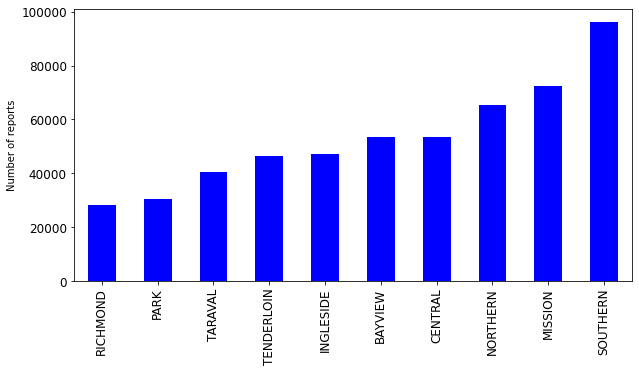

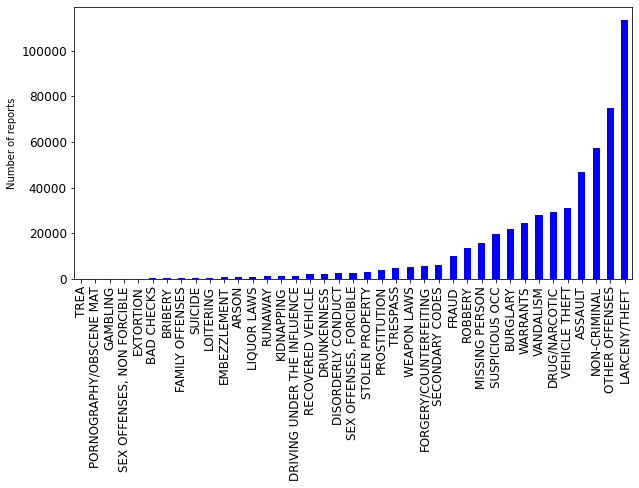

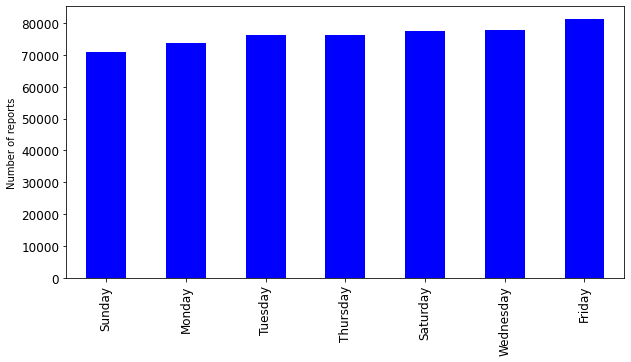

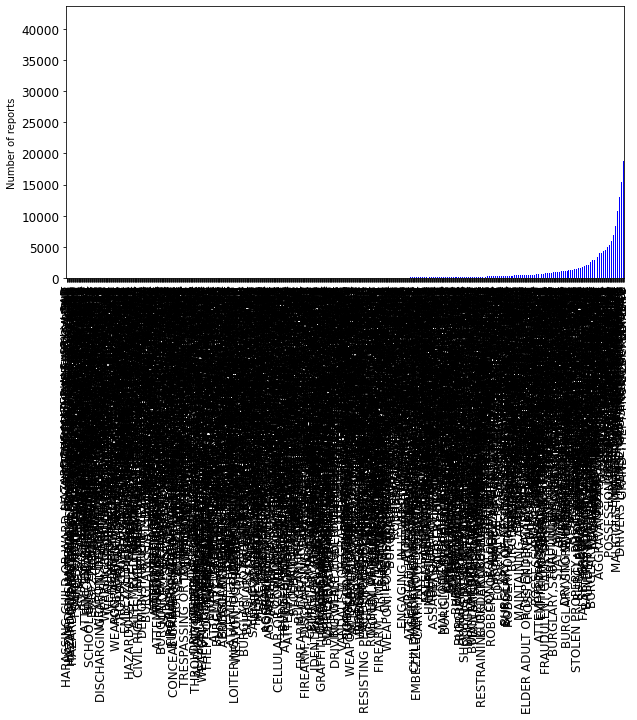

In [225]:
# Plotting some bargraphs.

plotdata(incidents, 'PdDistrict')
plotdata(incidents, 'Category')
plotdata(incidents, 'DayOfWeek')
plotdata(incidents, 'Descript')

In [226]:
# Why the 'Descript' bargraph is so strange? Check the large amount of different values that 'Descript' field have.

a = incidents.groupby('Descript').size()
a.sort_values()

Descript
HAZARDOUS MATERIALS, SPILL LOAD                               1
ATTEMPTED RAPE WITH A GUN                                     1
HARASSING CHILD OR WARD BECAUSE OF PERSON'S EMPLOYMENT        1
ATTEMPTED MOTORCYCLE STRIP                                    1
STOLEN METALS, RECEIVING                                      1
                                                          ...  
DRIVERS LICENSE, SUSPENDED OR REVOKED                     15339
STOLEN AUTOMOBILE                                         15767
BATTERY                                                   16396
LOST PROPERTY                                             18694
GRAND THEFT FROM LOCKED AUTO                              41509
Length: 847, dtype: int64

In [227]:
# Creating a function to represent heatmaps and hierarchical clusterings.
    
def plotdata1 (data, percentile):
    
    # Group by crime type and district. Use value_counts to count and sort them in a descending way. 
        # Use pandas.DataFrame.unstack() to show data in a table. Use pandas.DataFrame.fillna(x) to fill null values with 'x'.
    
    crimes_per_district = data.groupby('Descript').PdDistrict.value_counts(sort = True)
    crimes_per_district = crimes_per_district.unstack().fillna(0)

    # Sort data by total crimes by district sum.
        # Use pandas.DataFrame.sum to get the total amount. Select 0 or 1 in 'axis' to sum by indexes or by columns.
        # Sort values in descending order.
        # Create a new index.
        
    total_crimes_per_district = crimes_per_district.sum(axis = 0)
    total_crimes_per_district.sort_values(ascending = False)
    crimes_per_district = crimes_per_district[total_crimes_per_district.index]
    
    # Sort data by total crimes type sum.
    
    total_crimes_per_type = crimes_per_district.sum(axis = 1)
    total_crimes_per_type = total_crimes_per_type.sort_values(ascending = False)
    
    # Slice data using percentiles.
        # Use numpy.percentile(a, q) to compute the q-th percentile of the data (a) along the specified axis.
        
    p = np.percentile(total_crimes_per_type, percentile)
    ix = total_crimes_per_type[total_crimes_per_type > p]
    crimes_per_district = crimes_per_district.loc[ix.index]
    return crimes_per_district
    

In [228]:
# Check the percentile part of the function works properly.

crimes_per_district = plotdata1(incidents, 90)
print(crimes_per_district)

PdDistrict                             BAYVIEW  CENTRAL  INGLESIDE  MISSION  \
Descript                                                                      
GRAND THEFT FROM LOCKED AUTO            2651.0   6211.0     2035.0   3159.0   
LOST PROPERTY                            905.0   3138.0      980.0   2311.0   
BATTERY                                 1514.0   1762.0     1455.0   2447.0   
STOLEN AUTOMOBILE                       1959.0   1232.0     2693.0   2240.0   
DRIVERS LICENSE, SUSPENDED OR REVOKED   3150.0    953.0     1988.0   2075.0   
...                                        ...      ...        ...      ...   
VEHICLE, RECOVERED, OTHER VEHICLE        213.0     82.0      213.0    201.0   
ATTEMPTED THEFT FROM LOCKED VEHICLE      113.0    145.0      101.0    106.0   
GRAND THEFT SHOPLIFTING                   14.0    342.0       26.0     62.0   
HARASSING PHONE CALLS                    119.0    147.0      155.0    116.0   
BURGLARY OF STORE, UNLAWFUL ENTRY         28.0    17

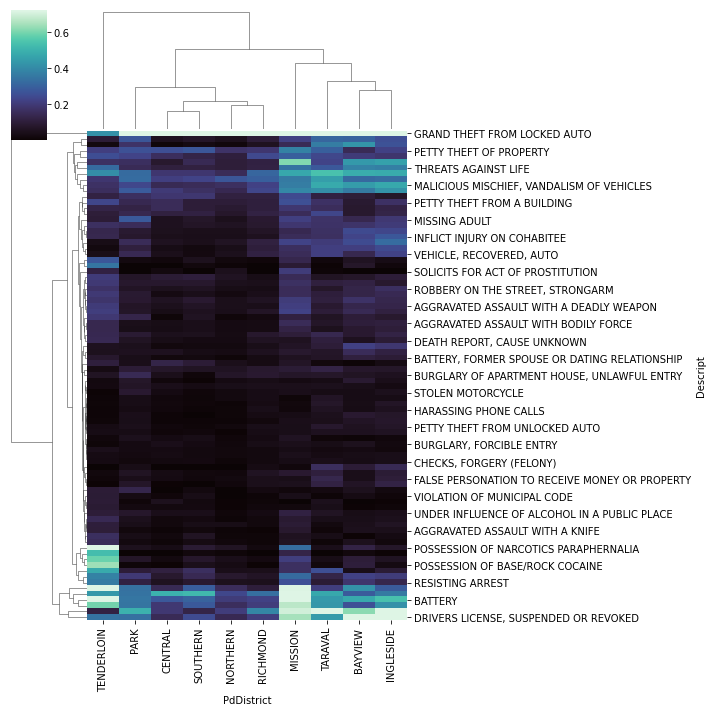

In [229]:
# Use seaborn.clustermap to plot a matrix dataset as a hierarchically-clustered heatmap.
    # The lower percentile we choose, the more results the heatmap will have.
    # Use 'cmap' option to change the cluster map colour. Some examples are 'mako', 'rocket', 'flare', 'crest', 'magma', 'viridis', etc.
    # Use 'robust' option and equals it to True to emphasize the cluster map colours.
    # Use standard_scale = 0 or 1 to standardize or not each dimension, subtract the minimum and divide each by its maximum.

sns.clustermap(crimes_per_district, standard_scale = 1, cmap = 'mako', robust = True)

In [230]:
# Connecting to MongoDB using our credentials and creating a new collection.

print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017, username = 'dbatest', password = 'dPMd#Vg%lBpb', authSource = 'admin')
db = client.test
collection = db.crimesf

Mongo version 3.11.2


In [231]:
# Import data into the new collection.
    # Drop the new collection to ensure it is empty.

collection.drop()

In [232]:
# Import data into the new collection.
    # Transform the main CSV file to JSON using pandas.DataFrame.to_json and load it using json.loads.

records = json.loads(incidents.to_json(orient = 'records'))

In [233]:
# Import data into the new collection.
    # Delete all the records to check the collection is empty.

collection.delete_many({})

In [234]:
# Import data into the new collection.
    # Insert the JSON records into the collection using collection.insert_many.
    
collection.insert_many(records)

In [235]:
# Checking whether the importation has been OK printing some records.

cursor = collection.find().limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('601015f04139af2df32fbb35'), 'IncidntNum': 100672773, 'Category': 'OTHER OFFENSES', 'Descript': 'TRAFFIC VIOLATION', 'DayOfWeek': 'Friday', 'Date': '07/23/2010 12:00:00 AM', 'Time': '00:53', 'PdDistrict': 'INGLESIDE', 'Resolution': 'ARREST, CITED', 'Address': 'MISSION ST / PERSIA AV', 'X': -122.435977217, 'Y': 37.7231288307, 'Location': '(37.7231288306727, -122.43597721703)', 'Days': 2760.0}
{'_id': ObjectId('601015f04139af2df32fbb36'), 'IncidntNum': 60008050, 'Category': 'LARCENY/THEFT', 'Descript': 'PETTY THEFT FROM LOCKED AUTO', 'DayOfWeek': 'Wednesday', 'Date': '12/28/2005 12:00:00 AM', 'Time': '09:00', 'PdDistrict': 'BAYVIEW', 'Resolution': 'NONE', 'Address': '800 Block of MINNESOTA ST', 'X': -122.3902620155, 'Y': 37.7591168554, 'Location': '(37.7591168554234, -122.390262015502)', 'Days': 1092.0}
{'_id': ObjectId('601015f04139af2df32fbb37'), 'IncidntNum': 150307550, 'Category': 'NON-CRIMINAL', 'Descript': 'AIDED CASE, MENTAL DISTURBED', 'DayOfWeek': 'Tuesday', 'Da

In [236]:
# Establishing a pipeline to select all rows matching attribute "Category" = "VANDALISM"

pipeline = [{"$match": {"Category": "VANDALISM"}}]

In [237]:
# Querying the collection with the pipeline filter and showing some results to check everything is OK.

vandalismResults = collection.aggregate(pipeline)
df = pd.DataFrame(list(vandalismResults))
df.head()

_id  IncidntNum   Category  \
0  601015f04139af2df32fbb6d   140954428  VANDALISM   
1  601015f04139af2df32fbb7b    70088616  VANDALISM   
2  601015f04139af2df32fbb87   150657208  VANDALISM   
3  601015f04139af2df32fbb8b   136109657  VANDALISM   
4  601015f04139af2df32fbb94    40082331  VANDALISM   

                                    Descript  DayOfWeek  \
0  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   
1              MALICIOUS MISCHIEF, VANDALISM  Wednesday   
2  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES     Monday   
3              MALICIOUS MISCHIEF, VANDALISM     Sunday   
4  MALICIOUS MISCHIEF, VANDALISM OF VEHICLES  Wednesday   

                     Date   Time PdDistrict Resolution  \
0  11/10/2014 12:00:00 AM  19:20  INGLESIDE       NONE   
1  01/24/2007 12:00:00 AM  19:00   SOUTHERN       NONE   
2  07/27/2015 12:00:00 AM  23:00  INGLESIDE       NONE   
3  06/30/2013 12:00:00 AM  19:00    TARAVAL       NONE   
4  01/21/2004 12:00:00 AM  04:30   NORTHERN       NONE   

                    Address           X          Y  \
0  3300 Block of MISSION ST -122.421644  37.742997   
1       600 Block of 7TH ST -122.402367  37.772461   
2     100 Block of BANKS ST -122.412705  37.740841   
3   HIGUERA AV / ARBALLO DR -122.483150  37.718391   
4      800 Block of FELL ST -122.431835  37.774742   

                                Location    Days  
0  (37.7429970144076, -122.421644478447)  4331.0  
1  (37.7724610410735, -122.402366997531)  1484.0  
2   (37.740841244439, -122.412704829011)  4590.0  
3  (37.7183912323253, -122.483149907764)  3833.0  
4   (37.7747415107981, -122.43183473707)   385.0

In [238]:
# Counting the total amount of rows about vandalism.

collection.find({"Category": "VANDALISM"}).count()

<ipython-input-238-de6c9ec55840>:3: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  collection.find({"Category": "VANDALISM"}).count()


27791

In [239]:
# Displaying all the vandalism types there are.

vandalism_types = df['Descript'].value_counts()
print(vandalism_types)

MALICIOUS MISCHIEF, VANDALISM OF VEHICLES                   10776
MALICIOUS MISCHIEF, VANDALISM                               10668
MALICIOUS MISCHIEF, BREAKING WINDOWS                         2872
MALICIOUS MISCHIEF, GRAFFITI                                 2109
MALICIOUS MISCHIEF                                            251
MALICIOUS MISCHIEF, TIRE SLASHING                             215
MALICIOUS MISCHIEF, STREET CARS/BUSES                         206
VANDALISM OR GRAFFITI TOOLS, POSSESSION                       172
MALICIOUS MISCHIEF, ADULT SUSPECT                             145
MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN              142
MALICIOUS MISCHIEF, JUVENILE SUSPECT                           45
VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY           38
MALICIOUS MISCHIEF, BUILDING UNDER CONSTRUCTION                30
GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION       30
MALICIOUS MISCHIEF, FICTITIOUS PHONE CALLS                     27
DAMAGE TO 

In [240]:
# Creating a function to represent heatmaps and hierarchical clusterings.
    
def plotdata2 (data, percentile):
    
    # Group by vandalism act type and district. Use value_counts to count and sort them in a descending way. 
        # Use pandas.DataFrame.unstack() to show data in a table. Use pandas.DataFrame.fillna(x) to fill null values with 'x'.
    
    vandalism_per_district = data.groupby('Descript').PdDistrict.value_counts(sort = True)
    vandalism_per_district = vandalism_per_district.unstack().fillna(0)

    # Sort data by total vandalism by district sum.
        # Use pandas.DataFrame.sum to get the total amount. Select 0 or 1 in 'axis' to sum by indexes or by columns.
        # Sort values in descending order.
        # Create a new index.
        
    total_vandalism_per_district = vandalism_per_district.sum(axis = 0)
    total_vandalism_per_district.sort_values(ascending = False)
    vandalism_per_district = vandalism_per_district[total_vandalism_per_district.index]
    
    # Sort data by total vandalism act type sum.
    
    total_vandalism_per_type = vandalism_per_district.sum(axis = 1)
    total_vandalism_per_type = total_vandalism_per_type.sort_values(ascending = False)
    
    # Slice data using percentiles.
        # Use numpy.percentile(a, q) to compute the q-th percentile of the data (a) along the specified axis.
        
    p = np.percentile(total_vandalism_per_type, percentile)
    ix = total_vandalism_per_type[total_vandalism_per_type > p]
    vandalism_per_district = vandalism_per_district.loc[ix.index]
    return vandalism_per_district
    

In [241]:
# Calculating the vandalism acts per district within a percentil given using the function "plotdata1" created before.

vandalism_per_district = plotdata2(df, 25)
print(vandalism_per_district)

PdDistrict                                          BAYVIEW  CENTRAL  \
Descript                                                               
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES            1418.0    949.0   
MALICIOUS MISCHIEF, VANDALISM                        1141.0   1276.0   
MALICIOUS MISCHIEF, BREAKING WINDOWS                  501.0    362.0   
MALICIOUS MISCHIEF, GRAFFITI                          147.0    224.0   
MALICIOUS MISCHIEF                                     34.0     36.0   
MALICIOUS MISCHIEF, TIRE SLASHING                      40.0     14.0   
MALICIOUS MISCHIEF, STREET CARS/BUSES                  22.0     11.0   
VANDALISM OR GRAFFITI TOOLS, POSSESSION                 8.0     11.0   
MALICIOUS MISCHIEF, ADULT SUSPECT                      18.0     21.0   
MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN       24.0     12.0   
MALICIOUS MISCHIEF, JUVENILE SUSPECT                   14.0      4.0   
VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HI...      6.0     

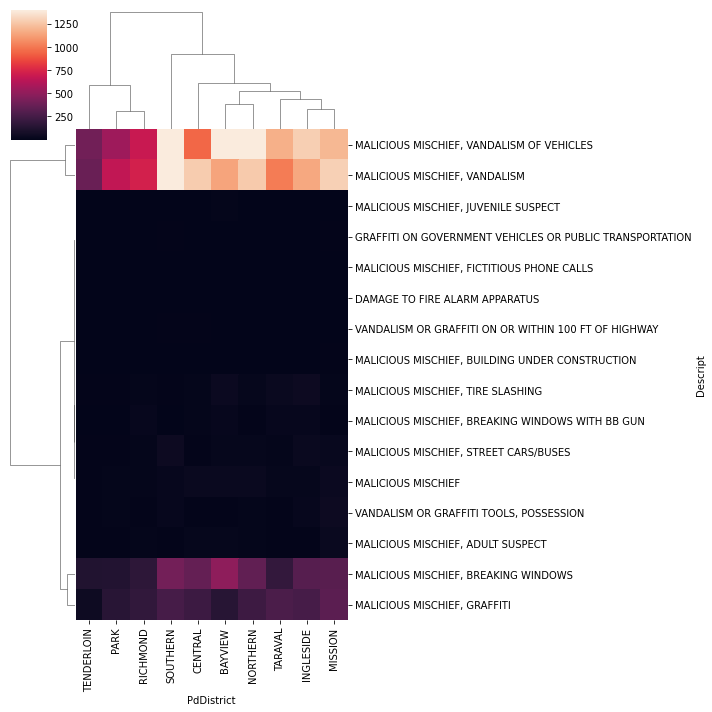

In [242]:
# Using a heatmap is very easy to find out that San Francisco has a big problem with the vandalism of vehicles.
# Graffities and broken windows are other problematic vandalism acts.
# It is surprising that Tenderloin does not have big problems about vandalism, unlike it has with drugs or narcotics.

sns.clustermap(vandalism_per_district, robust = True)

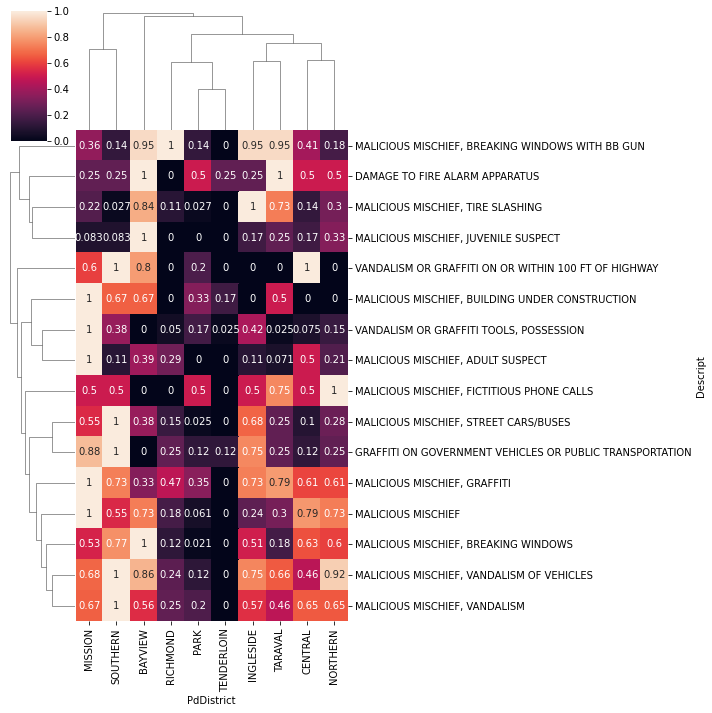

In [243]:
# If the standard scale value is changed to 1 it is more clear that Tenderloin does not have barely vandalism problems.
# Mission, Bayview and Southern are both the worst districts on that issue.

sns.clustermap(vandalism_per_district, standard_scale = 0, annot = True, robust = True)

In [244]:
# Creating a new column named 'Months'.

df['Months']=np.floor(df['Days']/30) # Approximate month (30 day window)

df.sample(1)

_id  IncidntNum   Category  \
10114  601015f24139af2df332b1ab    76032621  VANDALISM   

                            Descript  DayOfWeek                    Date  \
10114  MALICIOUS MISCHIEF, VANDALISM  Wednesday  05/16/2007 12:00:00 AM   

        Time PdDistrict Resolution            Address           X          Y  \
10114  20:30   RICHMOND       NONE  28TH AV / ANZA ST -122.487805  37.778018   

                                    Location    Days  Months  
10114  (37.7780181704525, -122.487804944314)  1596.0    53.0

In [245]:
# Default
district = 'All'

In [246]:
# Creating a new function to represent vandalism acts.
    
def timeseries (data, percentile):
    ''' Vandalism grouped by month '''
    
    # Group by vandalism description and month. Use value_counts to count and sort them in a descending way. 
        # Use pandas.DataFrame.unstack() to show data in a table. Use pandas.DataFrame.fillna(x) to fill null values with 'x'.
    
    vandalism_per_month = data.groupby('Months').Descript.value_counts(sort = True)
    vandalism_per_month = vandalism_per_month.unstack().fillna(0)

    # Sort data by total vandalism sum.
        # Use pandas.DataFrame.sum to get the total amount. Select 0 or 1 in 'axis' to sum by indexes or by columns.
        # Sort values.

    total_vandalism = vandalism_per_month.sum(axis = 0)
    total_vandalism.sort_values()
    
    # Slice data using percentiles.
        
    p = np.percentile(total_vandalism, percentile)
    ix = total_vandalism[total_vandalism > p]
    vandalism_per_month = vandalism_per_month[ix.index]
    return vandalism_per_month

In [247]:
# Showing results according to the data and the percentile entered.

vandalism_per_month_all = timeseries(df, 10)

In [248]:
# Find descriptions with the word "GRAFFITI" on it using the 're' package.
    # re.compile is a function that compile a regular expression pattern into a regular expression object.
    # Use re.compile(re.I) to ignore case and perform case-insensitive matching.
    # Use a pipeline to select all rows matching attribute "Category" = "VANDALISM" and query the collection with the pipeline filter.

pattern = re.compile(r'GRAFFITI', re.I)

pipeline = [{"$match": {"Category":"VANDALISM" , 'Descript': {'$regex': pattern}}}]

graffiti_results = collection.aggregate(pipeline)
graffiti_df = pd.DataFrame(list(graffiti_results))
graffiti_df.head()

_id  IncidntNum   Category  \
0  601015f04139af2df32fbda5    50686575  VANDALISM   
1  601015f04139af2df32fc05d    90580200  VANDALISM   
2  601015f04139af2df32fc200    70589244  VANDALISM   
3  601015f04139af2df32fc251    90151942  VANDALISM   
4  601015f04139af2df32fc2a6    80447933  VANDALISM   

                       Descript DayOfWeek                    Date   Time  \
0  MALICIOUS MISCHIEF, GRAFFITI  Thursday  06/09/2005 12:00:00 AM  22:00   
1  MALICIOUS MISCHIEF, GRAFFITI  Thursday  06/04/2009 12:00:00 AM  18:00   
2  MALICIOUS MISCHIEF, GRAFFITI  Thursday  06/07/2007 12:00:00 AM  18:00   
3  MALICIOUS MISCHIEF, GRAFFITI    Sunday  02/08/2009 12:00:00 AM  21:00   
4  MALICIOUS MISCHIEF, GRAFFITI    Monday  04/28/2008 12:00:00 AM  22:00   

  PdDistrict Resolution                    Address           X          Y  \
0   NORTHERN       NONE   LAGUNA ST / GREENWICH ST -122.430940  37.799579   
1    TARAVAL       NONE     2900 Block of YORBA ST -122.498016  37.734658   
2    TARAVAL       NONE     2600 Block of OCEAN AV -122.473755  37.731854   
3    CENTRAL       NONE  1000 Block of COLUMBUS AV -122.415703  37.804188   
4    TARAVAL       NONE   0 Block of STONECREST DR -122.472757  37.728852   

                                Location    Days  
0  (37.7995788882894, -122.430939617966)   890.0  
1  (37.7346581776337, -122.498016150052)  2346.0  
2   (37.731854134109, -122.473754991713)  1618.0  
3  (37.8041876050837, -122.415703120443)  2230.0  
4  (37.7288520705314, -122.472757303533)  1944.0

In [249]:
# Grouping and showing graffiti vandalic acts from the 'graffiti_df' DataFrame.

graffiti = graffiti_df.groupby('Descript').size()
s = pd.Series(graffiti)
print(s)

Descript
GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION      30
MALICIOUS MISCHIEF, GRAFFITI                                2109
VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY          38
VANDALISM OR GRAFFITI TOOLS, POSSESSION                      172
dtype: int64


In [250]:
s = s[s != 1]

In [251]:
# Showing the above results in a list form.

graffiti_features = list(s.index)
print(graffiti_features)

['GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION', 'MALICIOUS MISCHIEF, GRAFFITI', 'VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY', 'VANDALISM OR GRAFFITI TOOLS, POSSESSION']


In [252]:
# It is possible to do the previous process through a function.
    # Use pandas.Series to generate one-dimensional ndarray with axis labels.
    # Use s = s[s != 1] to avoid those descriptions with value is = 1

def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
   
    pipeline = [{"$match": {"Category": "VANDALISM" , 'Descript': {'$regex': pat}}}]
    
    vandalism_results = collection.aggregate(pipeline)
    vandalism_df = pd.DataFrame(list(vandalism_results))
    vandalism = vandalism_df.groupby('Descript').size()
    s = pd.Series(vandalism)
    s = s[s != 1]
    features = list(s.index)
    
    return features

In [253]:
# Filtering by some different patterns.

vehicles_features = descriptionsAccordingToPattern('VEHICLES')
fire_features = descriptionsAccordingToPattern('FIRE')
tire_features = descriptionsAccordingToPattern('TIRE')
phone_features = descriptionsAccordingToPattern('PHONE')
gun_features = descriptionsAccordingToPattern('GUN')

print(graffiti_features)
print(vehicles_features)
print(fire_features)
print(tire_features)
print(phone_features)
print(gun_features)

['GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION', 'MALICIOUS MISCHIEF, GRAFFITI', 'VANDALISM OR GRAFFITI ON OR WITHIN 100 FT OF HIGHWAY', 'VANDALISM OR GRAFFITI TOOLS, POSSESSION']
['GRAFFITI ON GOVERNMENT VEHICLES OR PUBLIC TRANSPORTATION', 'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES']
['DAMAGE TO FIRE ALARM APPARATUS']
['MALICIOUS MISCHIEF, TIRE SLASHING']
['MALICIOUS MISCHIEF, FICTITIOUS PHONE CALLS']
['MALICIOUS MISCHIEF, BREAKING WINDOWS WITH BB GUN']


In [254]:
# Let's use real dates for plotting.

days_from_start = pd.Series(vandalism_per_month_all.index * 30).astype('timedelta64[D]')
dates_for_plot = date.min() + days_from_start
time_labels = dates_for_plot.map(lambda x: str(x.year) + '-' + str(x.month))

In [255]:
# Analytics per vandalism act according to descriptions.

def vandalism_analysis(v, district, plot):
    v['GRAFFITI'] = v[graffiti_features].sum(axis = 1)
    v['VEHICLES'] = v[vehicles_features].sum(axis = 1)
    v['FIRE'] = v[fire_features].sum(axis = 1)
    v['TIRE'] = v[tire_features].sum(axis = 1)
    v['PHONE'] = v[phone_features].sum(axis = 1)
    v['GUN'] = v[gun_features].sum(axis = 1)

    vandalism_acts = v[['GRAFFITI', 'VEHICLES', 'FIRE', 'TIRE', 'PHONE', 'GUN']]
    if plot:
        vandalism_acts.index = [int(i) for i in vandalism_acts.index]
        colors = plt.cm.jet(np.linspace(0, 1, vandalism_acts.shape[1]))
        vandalism_acts.plot(kind = 'bar', stacked = True, figsize = (20,5), color = colors, width = 1, title = district, fontsize = 6)
    return vandalism_acts

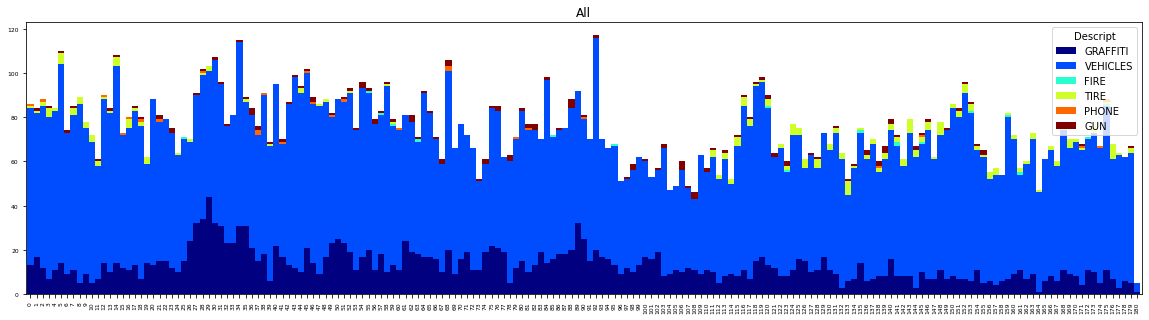

In [256]:
vandalism_df_all = vandalism_analysis(vandalism_per_month_all, district, True)

In [257]:
# Analytics per vandalism act according to descriptions rescaling the scale.

def vandalism_analysis_rescale(v, district, plot):
    v['GRAFFITI'] = v[graffiti_features].sum(axis = 1)
    v['VEHICLES'] = v[vehicles_features].sum(axis = 1)
    v['FIRE'] = v[fire_features].sum(axis = 1)
    v['TIRE'] = v[tire_features].sum(axis = 1)
    v['PHONE'] = v[phone_features].sum(axis = 1)
    v['GUN'] = v[gun_features].sum(axis = 1)

    vandalism_acts = v[['GRAFFITI', 'VEHICLES', 'FIRE', 'TIRE', 'PHONE', 'GUN']]
    if plot:
        vandalism_acts = vandalism_acts.div(vandalism_acts.sum(axis =1), axis = 0)
        vandalism_acts.index = [int(i) for i in vandalism_acts.index]
        colors = plt.cm.GnBu(np.linspace(0, 1, vandalism_acts.shape[1]))
        colors = plt.cm.jet(np.linspace(0, 1, vandalism_acts.shape[1]))
        vandalism_acts.plot(kind = 'bar', stacked = True, figsize = (20,5), color = colors, width = 1, title = district, fontsize = 6)
        plt.ylim([0, 1])
    return vandalism_acts

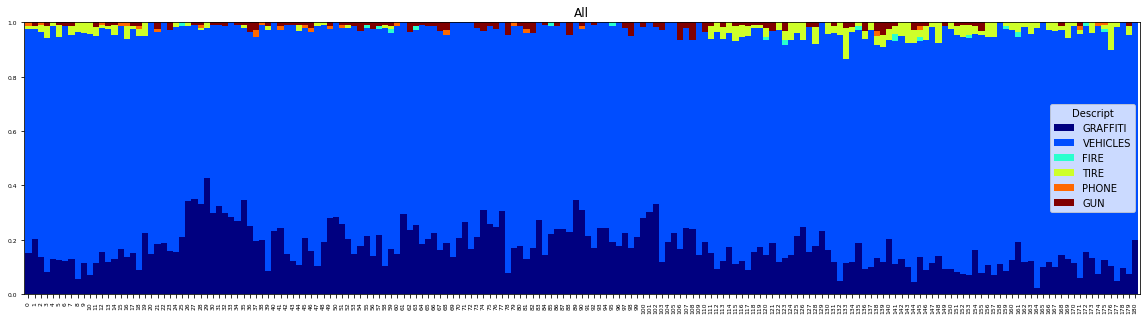

In [258]:
vandalism_df_all = vandalism_analysis_rescale(vandalism_per_month_all, district, True)

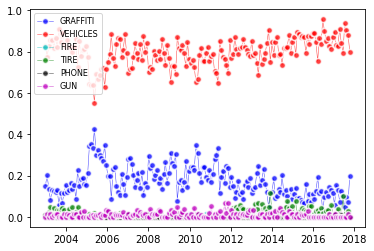

In [259]:
dates_for_plot.index = dates_for_plot
sns.set_context(rc = {"figure.figsize": (25.5,5.5)})

for d,c in zip(['GRAFFITI', 'VEHICLES', 'FIRE', 'TIRE', 'PHONE', 'GUN'],['b','r','c','g', 'k', 'm']):
    plt.plot(dates_for_plot.index, vandalism_df_all[d], 'o-', color = c, ms = 6, mew = 1.5,mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
    
plt.legend(loc = 'upper left', scatterpoints = 1, prop = {'size': 8})

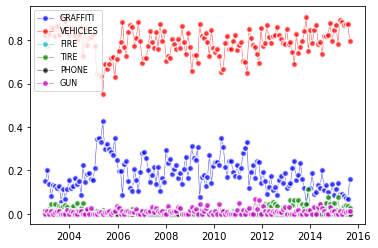

In [260]:
dates_for_plot.index = dates_for_plot
sns.set_context(rc = {"figure.figsize": (25.5,5.5)})

for d,c in zip(['GRAFFITI', 'VEHICLES', 'FIRE', 'TIRE', 'PHONE', 'GUN'],['b','r','c','g', 'k', 'm']):
    plt.plot(dates_for_plot.head(155).index, vandalism_df_all[d].head(155), 'o-', color = c, ms = 6, mew = 1.5,mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
    
plt.legend(loc = 'upper left', scatterpoints = 1, prop = {'size': 8})

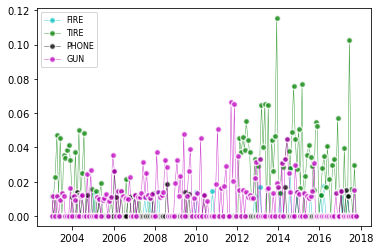

In [261]:
# Eliminate vehicles and graffiti..

dates_for_plot.index = dates_for_plot
sns.set_context(rc = {"figure.figsize": (25.5,5.5)})

for d,c in zip(['FIRE', 'TIRE', 'PHONE', 'GUN'],['c','g', 'k', 'm']):
    plt.plot(dates_for_plot.index, vandalism_df_all[d], 'o-', color = c, ms = 6, mew = 1.5,mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
    
plt.legend(loc = 'upper left', scatterpoints = 1, prop = {'size': 8})

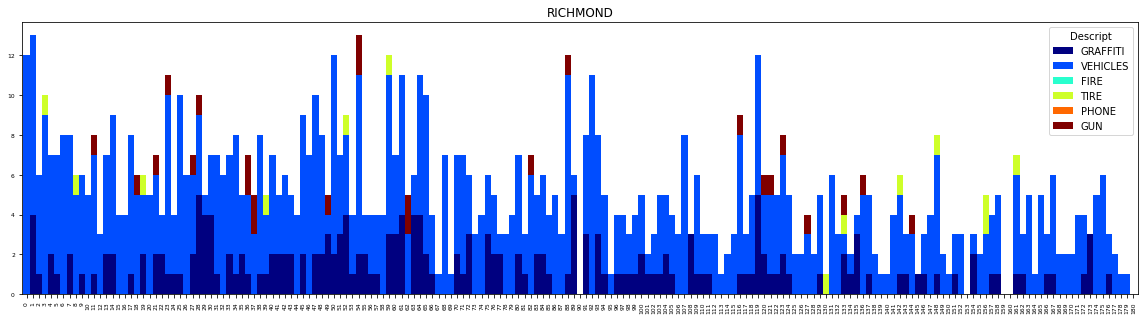

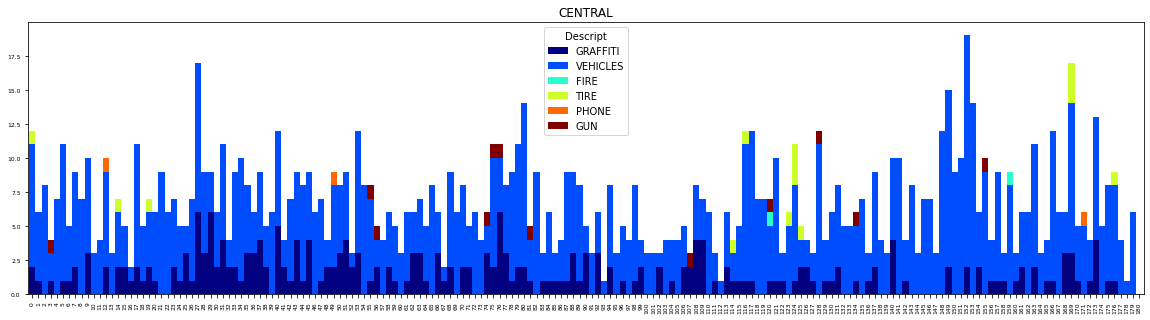

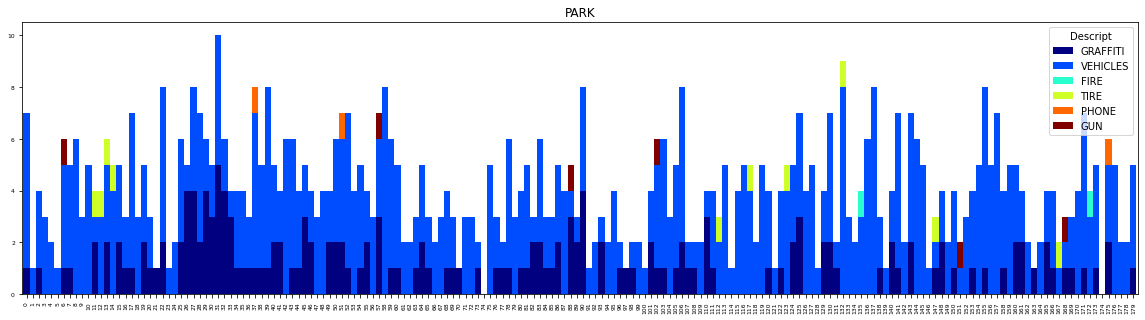

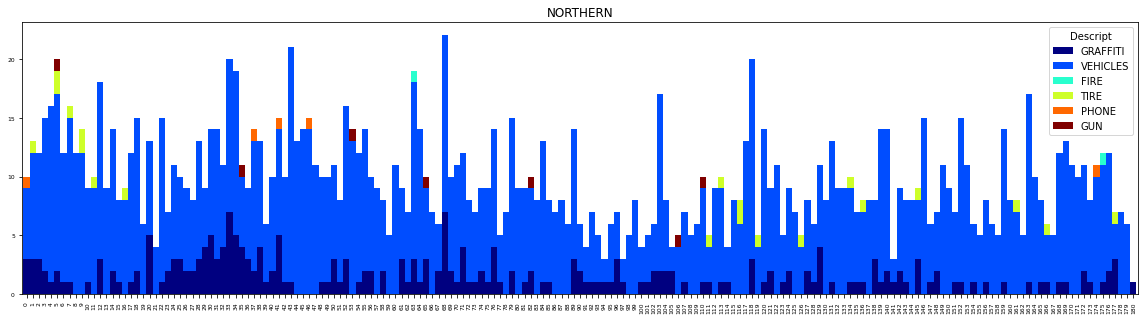

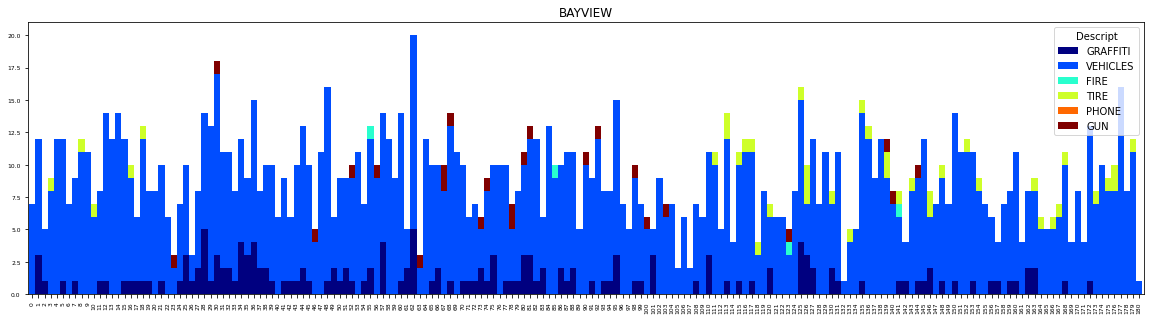

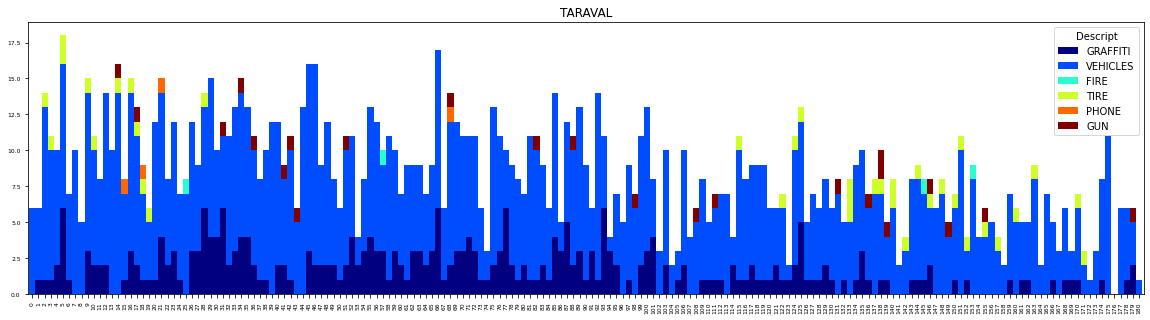

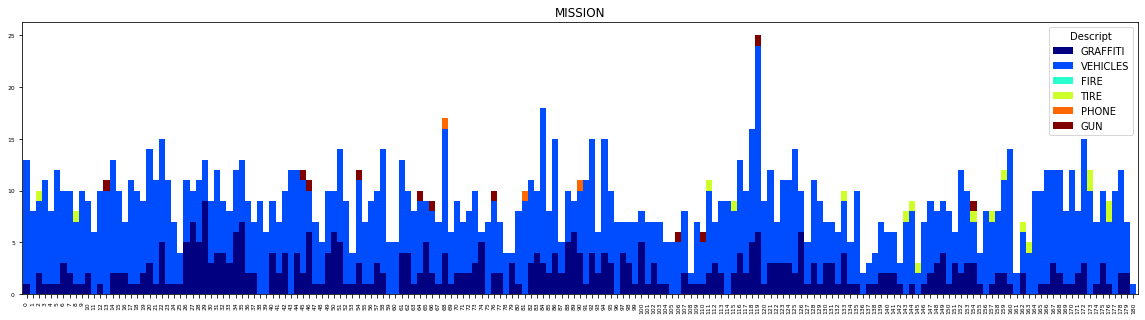

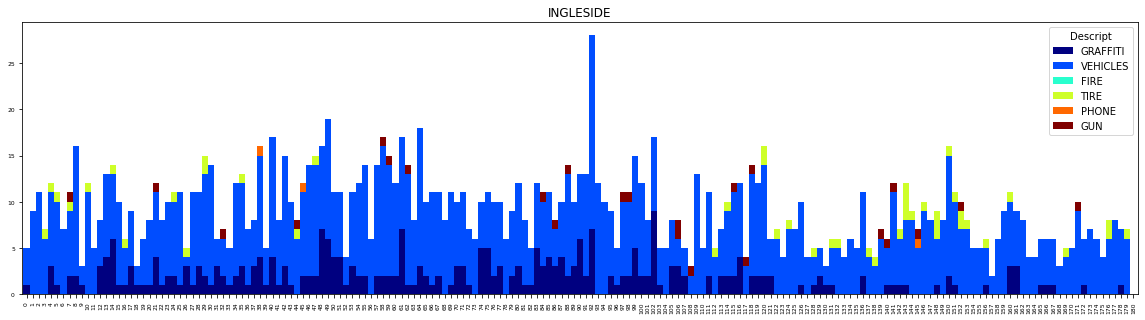

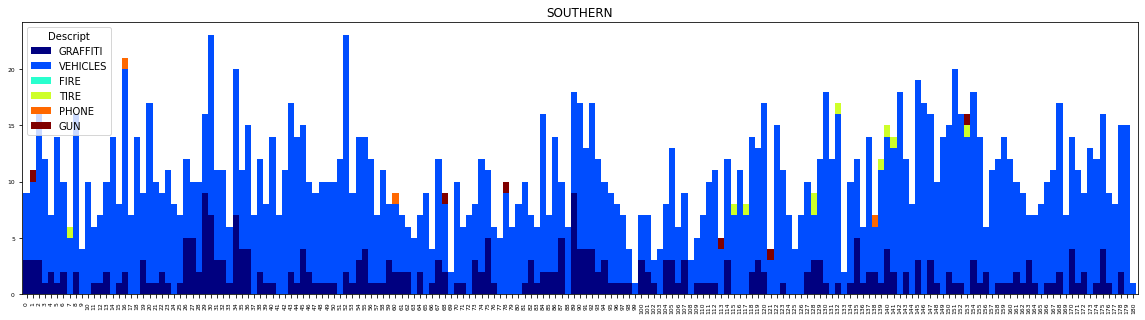

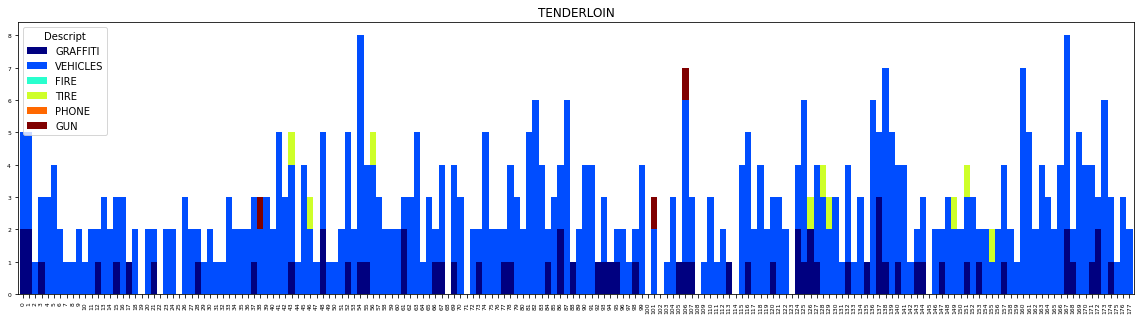

In [262]:
stor = []
stor_time = []

for d in set(incidents['PdDistrict']):
    # Specify district and group by time
    district_data = df[df['PdDistrict'] == d]
    v = timeseries(district_data, 0)
    # Merge to ensure all categories are preserved!
    v_merge = pd.DataFrame(columns = vandalism_per_month_all.columns)
    m = pd.concat([v_merge, v], axis = 0).fillna(0)
    m.reset_index(inplace = True)
    # Plot
    vandalism_df = vandalism_analysis(m, d, True)
    plt.show()
    s = vandalism_df.sum(axis = 0)
    stor = stor + [s]
    vandalism_df.columns = cols = [c + "_%s" % d for c in vandalism_df.columns]
    stor_time = stor_time + [vandalism_df]
    
vandalism_dat_time = pd.concat(stor_time, axis = 1)
vandalism_dat = pd.concat(stor, axis = 1)
vandalism_dat.columns = [list(set(incidents['PdDistrict']))]

<AxesSubplot:>

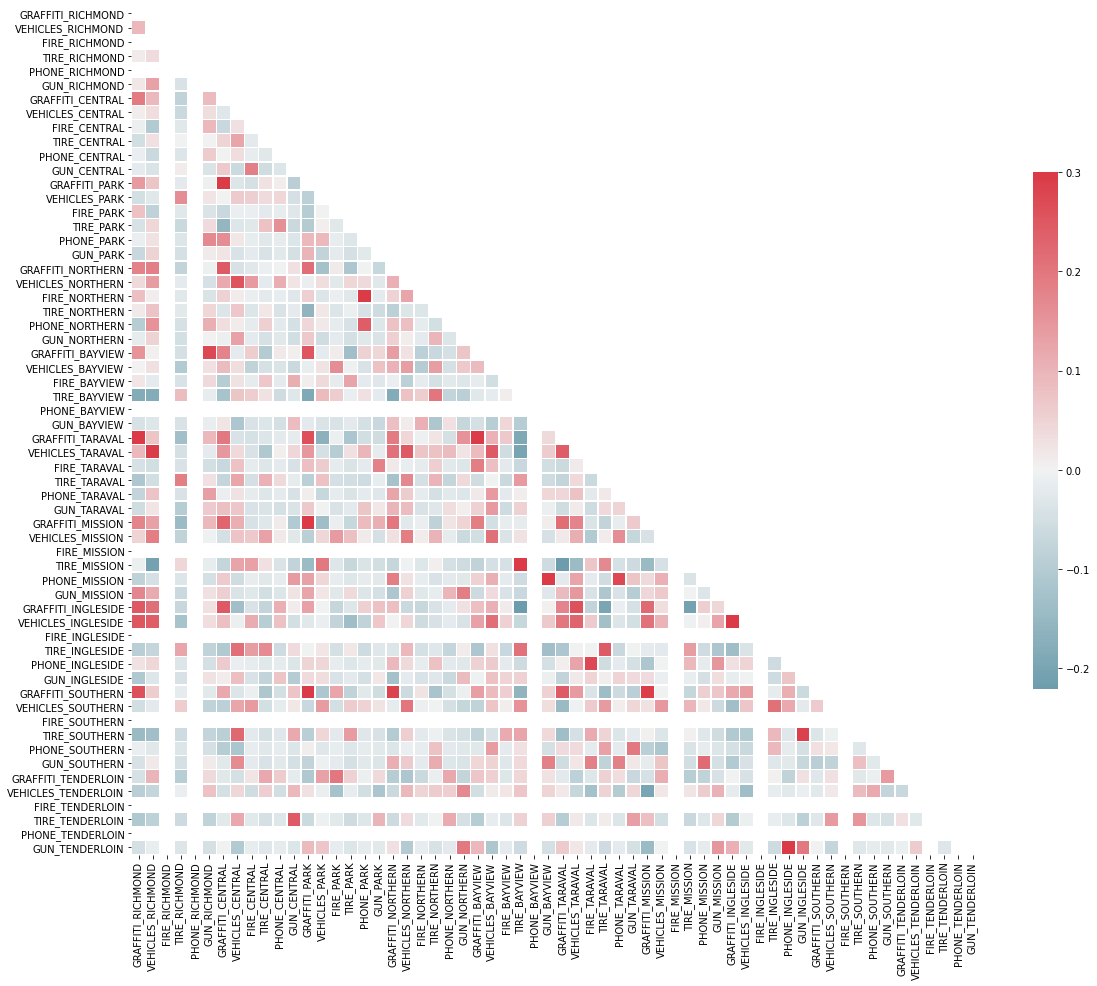

In [263]:
##We can also look at correlations between areas for different drugs.

sns.set_context(rc = {"figure.figsize": (20, 20)})
corr = vandalism_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (19, 19))

# Generate a custom diverging colormap
sns.set_context(rc = {"figure.figsize": (20, 20)})
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Plot the correlation heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": 0.5})

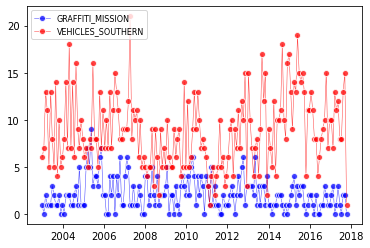

In [265]:
#With this in mind, we can examine select timeseries data.

vandalism_dat_time.index = dates_for_plot.head(181)
sns.set_context(rc = {"figure.figsize": (7.5, 5)})
for d, c in zip(['GRAFFITI_MISSION','VEHICLES_SOUTHERN'], ['b','r']):
    plt.plot(vandalism_dat_time.index, vandalism_dat_time[d], 'o-', color = c, ms = 6, mew = 1, mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
plt.legend(loc = 'upper left', scatterpoints = 1, prop = {'size': 8})

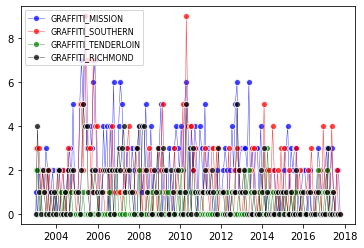

In [266]:
vandalism_dat_time.index = dates_for_plot.head(181)
sns.set_context(rc = {"figure.figsize": (7.5, 5)})
for d, c in zip(['GRAFFITI_MISSION','GRAFFITI_SOUTHERN', 'GRAFFITI_TENDERLOIN', 'GRAFFITI_RICHMOND'], ['b','r', 'g', 'k']):
    plt.plot(vandalism_dat_time.index, vandalism_dat_time[d], 'o-', color = c, ms = 6, mew = 1, mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
plt.legend(loc = 'upper left', scatterpoints = 1, prop = {'size': 8})

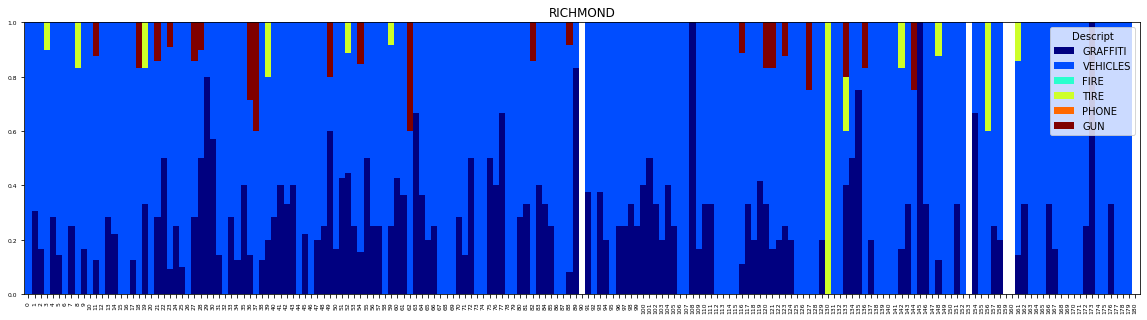

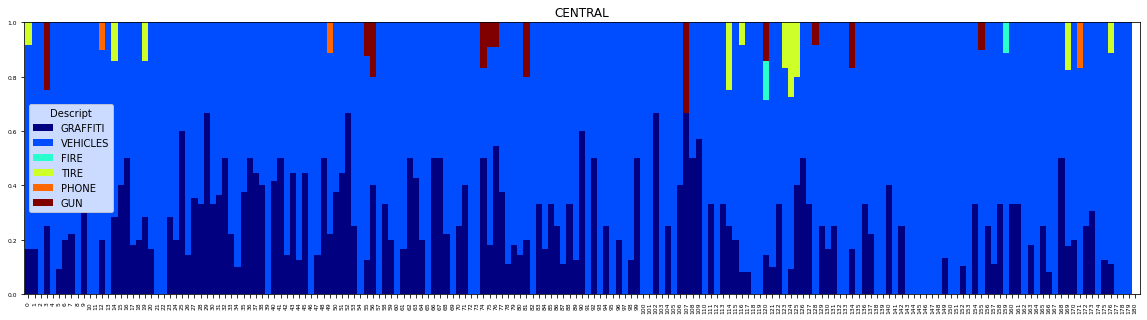

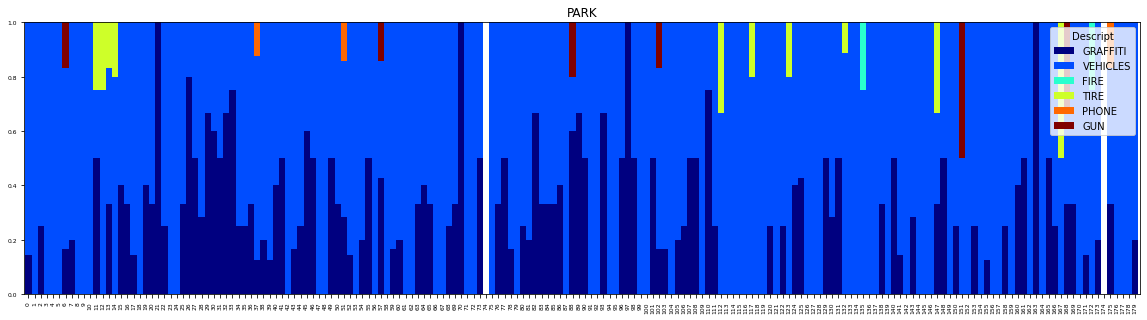

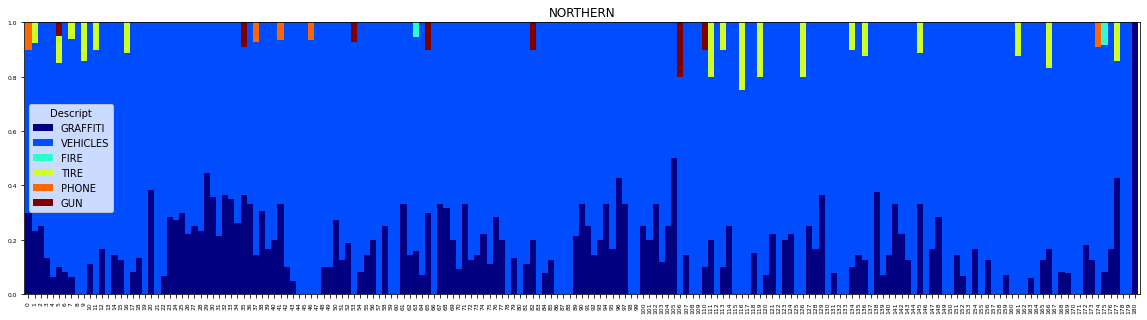

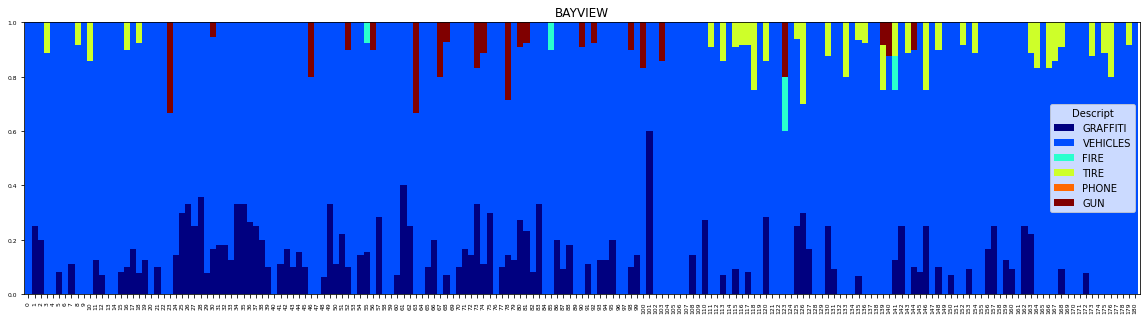

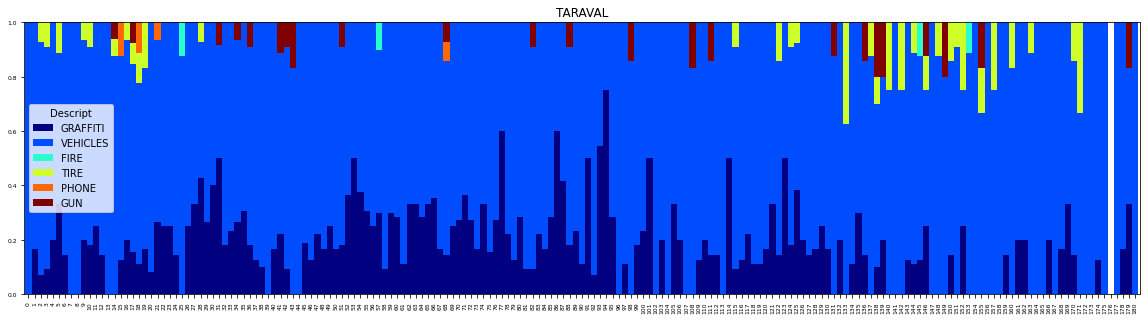

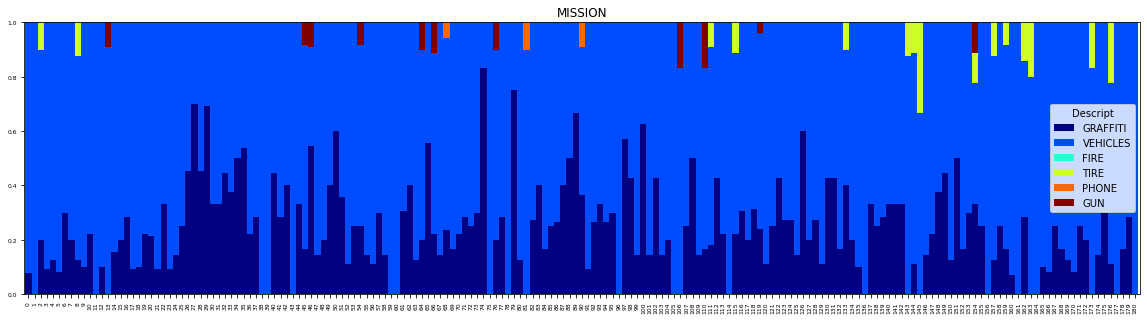

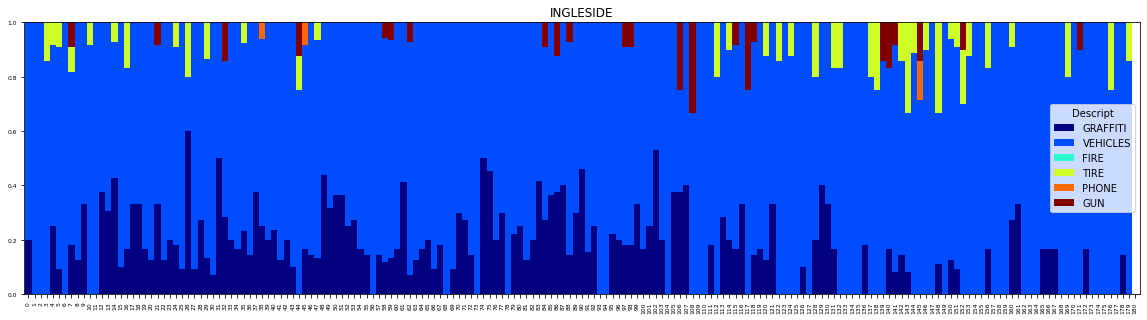

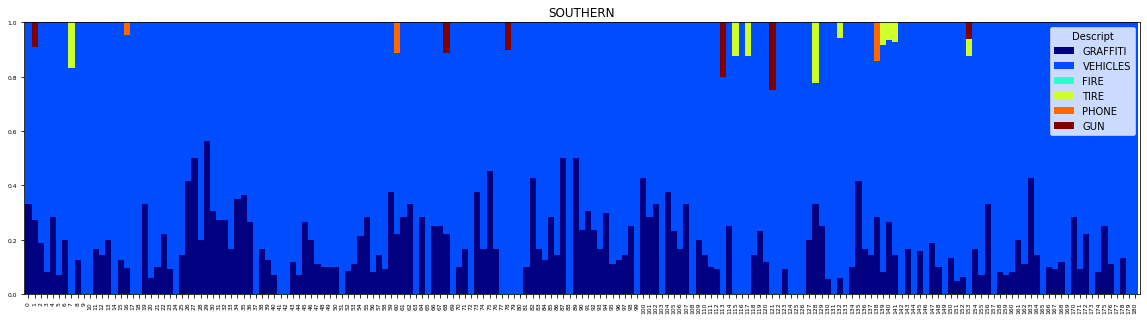

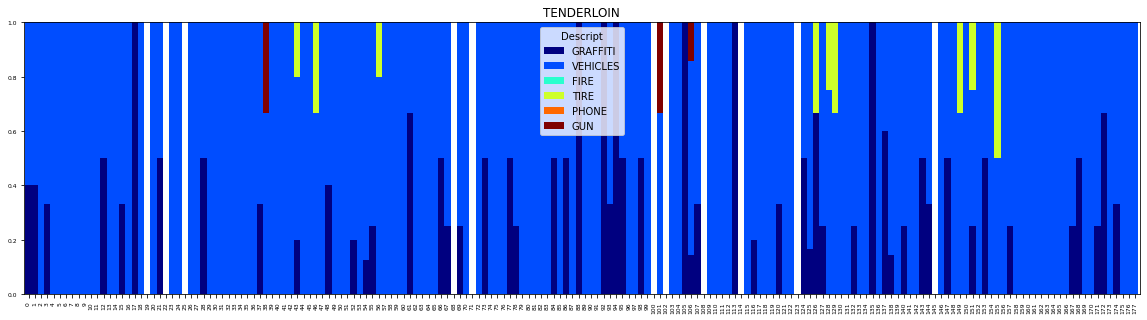

In [267]:
stor = []
stor_time = []

for d in set(incidents['PdDistrict']):
    # Specify district and group by time
    district_data = df[df['PdDistrict'] == d]
    v = timeseries(district_data, 0)
    # Merge to ensure all categories are preserved!
    v_merge = pd.DataFrame(columns = vandalism_per_month_all.columns)
    m = pd.concat([v_merge, v], axis = 0).fillna(0)
    m.reset_index(inplace = True)
    # Plot
    vandalism_df = vandalism_analysis_rescale(m, d, True)
    plt.show()
    s = vandalism_df.sum(axis = 0)
    stor = stor + [s]
    vandalism_df.columns = cols = [c + "_%s" % d for c in vandalism_df.columns]
    stor_time = stor_time + [vandalism_df]
    
vandalism_dat_time = pd.concat(stor_time, axis = 1)
vandalism_dat = pd.concat(stor, axis = 1)
vandalism_dat.columns = [list(set(incidents['PdDistrict']))]

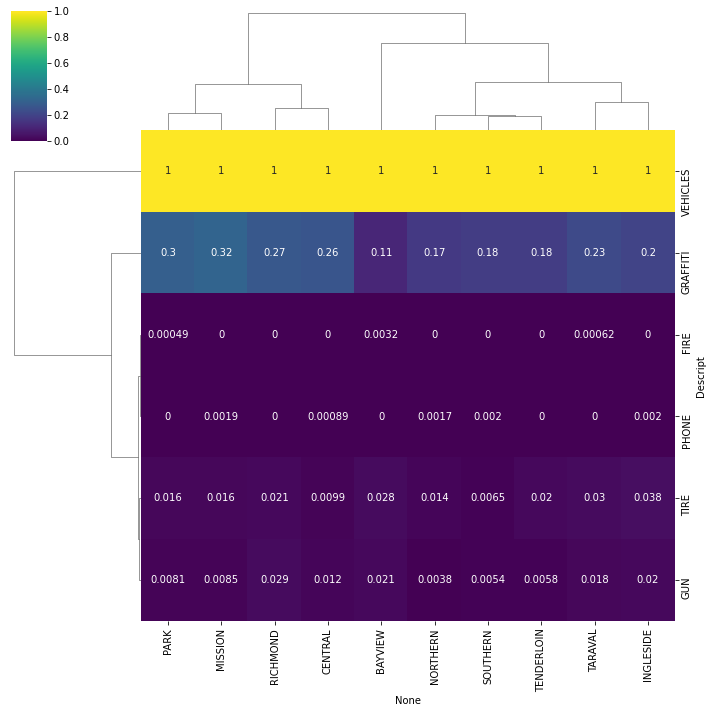

In [268]:
# We can now summarize this data using clustered heatmaps.
sns.clustermap(vandalism_dat, standard_scale = 1, cmap = "viridis", robust = True, annot = True)

In [271]:
#Let's isolate all graffiti-related records.

tmp = df.copy()
tmp.set_index('Descript', inplace = True)

graffiti_dat = tmp.loc[graffiti_features]
graffiti_pts = graffiti_dat[['X', 'Y', 'Months']]

In [274]:
#Plot the graffiti regimes.

d = pd.DataFrame(graffiti_pts.groupby('Months').size())
d.index = dates_for_plot.head(181)
d.columns = ['Count']

diff = len(d.index) - 120

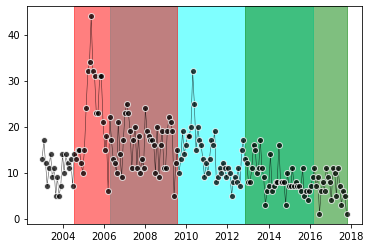

In [275]:
plt.plot(d.index, d['Count'], 'o-', color = 'k', ms = 6, mew = 1, mec = 'white', linewidth = 0.5, label = d, alpha = 0.75)
plt.axvspan(d.index[40-diff], d.index[40], color = 'cyan', alpha = 0.5)
plt.axvspan(d.index[80-diff], d.index[80], color = 'red', alpha = 0.5)
plt.axvspan(d.index[120], d.index[-1], color = 'green', alpha = 0.5)

In [276]:
oldest_graffiti_sums = d.loc[(d.index > d.index[40-diff]) & (d.index < d.index[40])]
old_graffiti_sums = d.loc[(d.index > d.index[80-diff]) & (d.index < d.index[80])]
new_graffiti_sums = d.loc[d.index > d.index[120]]

In [277]:
#Fold-difference in mean between the two regimes.
old_graffiti_sums['Count'].mean() / float(new_graffiti_sums['Count'].mean())

2.2299794661190964

In [280]:
#Two regimes.

oldest_graffiti = graffiti_pts[(graffiti_pts['Months'] > (40 - diff)) & (graffiti_pts['Months'] < 40)]
oldest_graffiti.columns = ['longitude', 'latitude', 'time']

old_graffiti = graffiti_pts[(graffiti_pts['Months'] > (80 - diff)) & (graffiti_pts['Months'] < 80)]
old_graffiti.columns = ['longitude', 'latitude', 'time']

new_graffiti = graffiti_pts[graffiti_pts['Months'] > 120]
new_graffiti.columns = ['longitude', 'latitude', 'time']

In [281]:
# Let's create MongoBD collections to manage and query data
col1 = db.cracko
col2 = db.crackn

#Import data into the database
col1.drop()
col2.drop()

In [282]:
# Collection for new graffiti
data_json1 = json.loads(new_graffiti.to_json(orient = 'records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [283]:
# Collection for old graffiti
data_json2 = json.loads(old_graffiti.to_json(orient = 'records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [286]:
#Check if you can access the data from the MongoDB.
cursor = col1.find().sort('time', pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)
    
print(" ")

cursor2 = col2.find().sort('time', pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('6010284e4139af2df337dee9'), 'longitude': -122.4409962807, 'latitude': 37.7154402669, 'time': 121.0}
{'_id': ObjectId('6010284e4139af2df337deae'), 'longitude': -122.4480431245, 'latitude': 37.7823710355, 'time': 121.0}
{'_id': ObjectId('6010284e4139af2df337deb2'), 'longitude': -122.4060218385, 'latitude': 37.7886491245, 'time': 121.0}
 
{'_id': ObjectId('601028624139af2df337e0a4'), 'longitude': -122.4111717906, 'latitude': 37.7590537638, 'time': 20.0}
{'_id': ObjectId('601028624139af2df337e23d'), 'longitude': -122.4090112066, 'latitude': 37.7811340568, 'time': 20.0}
{'_id': ObjectId('601028624139af2df337e24c'), 'longitude': -122.4232028036, 'latitude': 37.7740394664, 'time': 20.0}
{'_id': ObjectId('601028624139af2df337e0aa'), 'longitude': -122.4205156814, 'latitude': 37.7893840503, 'time': 20.0}
{'_id': ObjectId('601028624139af2df337e0ec'), 'longitude': -122.4272423802, 'latitude': 37.7614118084, 'time': 20.0}
{'_id': ObjectId('601028624139af2df337e15d'), 'longitude': 

In [289]:
# Use the following command to import the JSON file into MongoDB:

# mongoimport --db test --collection districts --authenticationDatabase admin --username "dbatest" --password "yourPassword" --drop --file /mongodb/Analysis_Neighborhoods.geojson

# And check everything is OK searching for one record.

cursor3 = col3.find().limit(1)
for doc in cursor3:
    print(doc)

{'_id': ObjectId('601029fea3ea066189077998'), 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'nhood': 'Bayview Hunters Point'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.38157774241415, 37.75307043091241], [-122.38156949251606, 37.753060959298274], [-122.38159239626694, 37.75309424492931], [-122.38155614326205, 37.753045901366754], [-122.38155137472305, 37.75304127677009], [-122.38154650687193, 37.753036719547374], [-122.3815415385967, 37.75303223061754], [-122.38153647334677, 37.75302781172802], [-122.38153131112232, 37.75302346287867], [-122.38152605423795, 37.753019185835115], [-122.38152070389688, 37.75301498328154], [-122.38151526236827, 37.75301085518192], [-122.38150973196667, 37.75300680330162], [-122.38150411158058, 37.75300282855954], [-122.38149840577098, 37.7529989317842], [-122.38149261460651, 37.75299511567804], [-122.38148674033339, 37.75299137930393], [-122.38148078528907, 37.75298772532827], [-122.38147475063121, 37.7529

In [295]:
# Create a new collection to store districts geo points

col3 = db.districts

In [296]:
# Get information about the index
col2.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]}}

In [297]:
col_temp = db.graffitin2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [298]:
cursor = col_temp.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('60102a724139af2df337e4ce'), 'loc': {'type': 'Point', 'coordinates': [-122.430939618, 37.7995788883]}}
{'_id': ObjectId('60102a724139af2df337e4cf'), 'loc': {'type': 'Point', 'coordinates': [-122.4980161501, 37.7346581776]}}
{'_id': ObjectId('60102a724139af2df337e4d0'), 'loc': {'type': 'Point', 'coordinates': [-122.4737549917, 37.7318541341]}}
{'_id': ObjectId('60102a724139af2df337e4d1'), 'loc': {'type': 'Point', 'coordinates': [-122.4157031204, 37.8041876051]}}
{'_id': ObjectId('60102a724139af2df337e4d2'), 'loc': {'type': 'Point', 'coordinates': [-122.4727573035, 37.7288520705]}}
{'_id': ObjectId('60102a724139af2df337e4d3'), 'loc': {'type': 'Point', 'coordinates': [-122.4351500998, 37.7617597244]}}
{'_id': ObjectId('60102a724139af2df337e4d4'), 'loc': {'type': 'Point', 'coordinates': [-122.4235729299, 37.7885214703]}}
{'_id': ObjectId('60102a724139af2df337e4d5'), 'loc': {'type': 'Point', 'coordinates': [-122.4503450752, 37.7742980584]}}
{'_id': ObjectId('60102a724139af2

In [299]:
cursor2 = col2.find_one()

In [300]:
# Create index in neighborhood GeoJson data
col3.create_index({"features.geometry": GEO2D})

TypeError: if no direction is specified, key_or_list must be an instance of list

In [301]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"], cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [302]:
cursor3 = col3.find_one(query)

In [303]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3["features"])

In [304]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [305]:
# Spatial query implementing getoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"], cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [306]:
# Have a look if everything is OK
for doc in collection_features.find(query_feat):
    print(doc)

{'_id': ObjectId('60102b184139af2df337ed5a'), 'type': 'Feature', 'properties': {'nhood': 'Marina'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.42662368167619, 37.80889254710134], [-122.4266361200163, 37.808794419893395], [-122.42663590228202, 37.80879478393554], [-122.4266360000741, 37.80879400008497], [-122.42661841461798, 37.808823309122225], [-122.42661647682242, 37.80879836275316], [-122.42660753022643, 37.80871265392649], [-122.42659866260509, 37.80864259337504], [-122.42659700048031, 37.80862699979836], [-122.42659529601124, 37.80861765322199], [-122.42658398704792, 37.80854167192482], [-122.4265693986699, 37.80845645178639], [-122.42655293710665, 37.808371446091606], [-122.42653673471189, 37.80829651352661], [-122.42653499979518, 37.80828699982072], [-122.42652200055036, 37.808151000088955], [-122.42652180474077, 37.8081510708785], [-122.4265217687845, 37.80815069205499], [-122.42649553671173, 37.80816055625287], [-122.42648642696419, 37.80816384578536], [-122.

In [307]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

{'nhood': 'Marina'}


In [308]:
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45) ## San Francisco Coordinates

In [309]:
MAX_RECORDS = 100
m = folium.Map(location = SF_COORDINATES, zoom_start = 12)

In [310]:
#Display neighborhoods by polygons
geo_json_data = json.load(open('C:\\Users\\Rafa\\Desktop\\Master Big Data\\Modulo 5\\Analysis_Neighborhoods.geojson'))
folium.GeoJson(geo_json_data).add_to(m)

In [311]:
# Display Old Graffiti points (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"], doc["longitude"]],
                  popup = 'Old Graffiti',
                  icon = folium.Icon(color = 'red')).add_to(m)

In [312]:
# Display New Graffiti Points (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"], doc["longitude"]],
                  popup = 'New Graffiti',
                  icon = folium.Icon(color = 'green')).add_to(m)

In [313]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"], cursor2["longitude"]],
                  popup = 'Selected Point',
                  icon = folium.Icon(color = 'blue')).add_to(m)

In [314]:
folium.LayerControl().add_to(m)

In [315]:
m.save(outfile = 'C:\\Users\\Rafa\\Desktop\\Master Big Data\\Modulo 5\\map1.html')

In [316]:
%%HTML
<iframe width = "100%" height = "350" src = "file:///C:\\Users\\Rafa\\Desktop\\Master Big Data\\Modulo 5\\map1.html?inline=true"></iframe>

In [317]:
# Obtaining the geometry of an Incident

map2 = folium.Map(location = SF_COORDINATES, zoom_start = 12)

In [318]:
folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

In [319]:
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map2)

In [320]:
folium.LayerControl().add_to(map2)

In [321]:
map2.save(outfile = 'C:\\Users\\Rafa\\Desktop\\Master Big Data\\Modulo 5\\map2.html')

In [323]:
m

In [326]:
map2